This will explore how importance scores from three different methods compare on simulated data.

The simulated data was as follows:
- 1/3rd sequences with 1-3 instances of a GATA_disc1 motif embedded (see http://compbio.mit.edu/encode-motifs/ for the PWM); these were labelled 1,0,0
- 1/3rd sequences with 1-3 instances of a TAL1_known1 motif embedded; these were labelled 0,1,0
- 1/3rd sequences with BOTH 1-3 instances of a GATA_disc1 motif AND 1-3 instances of a TAL1_known1 motif; these were labelled 1,1,1

Scores for all three tasks for sequences that contain both TAL1_known1 and GATA_disc1 motifs are analyzed in this notebook

First, we generate data to analyze. Let's make datasets with the same distribution of motifs as the data that the model was trained on (the model was not trained on this exact data)

In [1]:
%matplotlib inline

In [2]:
#Generate the data. Will install the simdna package if necessary.
try:
    import simdna
except ImportError, e:
    print("installing simdna package")
    !pip install git+git://github.com/kundajelab/simdna.git

#This will produce a warning about embedding a TAL1_known1 motif, which is normal
!./generate_data.sh

Read in the data

In [3]:
import simdna.synthetic as synthetic
tal_gata_filename = "DensityEmbedding_prefix-talgata_motifs-GATA_disc1+TAL1_known1_min-1_max-3_mean-2_zeroProb-0_seqLength-200_numSeqs-1000.simdata.gz"
#read in the data
tal_gata_data = synthetic.read_simdata_file(tal_gata_filename)

Load the keras model and convert the models to the importance-scoring format. We will compare methods of deeplift, gradient\*input and guided backprop\*input.

In [4]:
import deeplift
import deeplift.conversion.keras_conversion as kc
import numpy as np
from deeplift.blobs import MxtsMode
import keras

#load the keras model
#at the time of writing, this uses keras 0.3 and theano dimension ordering
keras_model_weights = "record_5_model_EKIIu_modelWeights.h5"
keras_model_yaml = "record_5_model_EKIIu_modelYaml.yaml"
keras_model = kc.load_keras_model(weights=keras_model_weights,
                                  yaml=keras_model_yaml)

#set the reference to something with gc content of background
default = (np.ones((1,4,200))*np.array([0.27, 0.23, 0.23, 0.27])[None,:,None]).astype('float32')
#default = (np.ones((1,4,200))*np.array([0.25, 0.25, 0.25, 0.25])[None,:,None]).astype('float32')

#make various kinds of importance scoring models
deeplift_model, grad_model, guided_backprop_model, guided_backprop_deeplift_model, pos_through_dense_model =\
    [kc.convert_graph_model(
        model=keras_model,
        mxts_mode=mxts_mode,
        default=default) for mxts_mode in [MxtsMode.DeepLIFT, MxtsMode.Gradient, MxtsMode.GuidedBackprop, MxtsMode.GuidedBackpropDeepLIFT, MxtsMode.PosThroughDenseDeepLIFT]]

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)
Using Theano backend.
/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


One-hot encode the sequence data

In [5]:
#install the avutils package if it isn't installed
try:
    import avutils
except ImportError, e:
    print("installing avutils package")
    !pip install git+git://github.com/kundajelab/avutils.git

import avutils
import avutils.util

#get one-hot encoded sequence for the tal_gata data
tal_gata_onehot = np.array([avutils.util.seq_to_2d_image(seq) for seq in tal_gata_data.sequences])

Double-check that the conversion happened correctly by making sure both the original keras model and the converted models are giving the same predictions (this is not strictly necessary for computing importance scores)

In [6]:
#make sure predictions are the same as the original model
from deeplift import backend as B
deeplift_prediction_func = B.function([deeplift_model.get_name_to_blob()['sequence'].get_activation_vars()],
                                       deeplift_model.get_name_to_blob()['output_act'].get_activation_vars())
original_model_predictions = keras_model.predict({'sequence':tal_gata_onehot}, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[tal_gata_onehot],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions['output'])) < 10**-5
tal_gata_predictions = converted_model_predictions

Sort the predictions by confidence, for use later

In [7]:
#taldata predictions sorted by confidence
tal_gata_predictions_sorted = sorted(enumerate(tal_gata_predictions), key=lambda x: -x[1][2])

Compute the importance scores using the three different methods for all three tasks

In [8]:
#compute the importance scores on the sequences
deeplift_func, grad_times_inp_func, guided_backprop_func, guided_backprop_deeplift_func, pos_through_dense_func =\
    [model.get_target_contribs_func(find_scores_layer_name="sequence",
                                    pre_activation_target_layer_name="output_preact")
     for model in [deeplift_model, grad_model, guided_backprop_model, guided_backprop_deeplift_model, pos_through_dense_model]]

from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
for method_name, score_func in [('deeplift', deeplift_func),
                               ('grad_times_inp', grad_times_inp_func),
                               ('guided_backprop_times_inp', guided_backprop_func),
                               ('guided_backprop_deeplift_times_inp', guided_backprop_deeplift_func),
                               ('deeplift_pos_through_dense', pos_through_dense_func)]:
    method_to_task_to_scores[method_name] = {}
    for task_idx in [0,1,2]:
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[tal_gata_onehot],
                    batch_size=200,
                    progress_update=None))
        assert scores.shape[2]==4
        scores = np.squeeze(np.sum(scores, axis=2),axis=1)
        method_to_task_to_scores[method_name][task_idx] = scores

In [9]:
motif_locations = {'GATA_disc1':[], 'TAL1_known1':[]}
for embeddings in tal_gata_data.embeddings:
    for motif in motif_locations:
        motif_locations[motif].append([])
    for embedding in embeddings:
        motif_locations[embedding.what.getDescription()][-1]\
                       .append((embedding.startPos, embedding.startPos+len(embedding.what)))

In [10]:
def compile_scores_on_motif_locations_vs_others(scores, valid_locations,
                                                smoothen_function, batch_size=200, progress_update=None):
    scores = smoothen_function(scores, batch_size=batch_size, progress_update=progress_update)
    scores_on_valid_locations = []
    scores_on_other_locations = []
    for scores_single_region,valid_locations_single_region in zip(scores, valid_locations):
        #sort valid locations in order
        sorted_valid_locations = sorted(valid_locations_single_region, key=lambda x: x[0])
        for i in range(len(sorted_valid_locations)):
            prev_end = 0 if i==0 else sorted_valid_locations[i-1][1]
            next_start = (len(scores_single_region)
                          if i==(len(sorted_valid_locations)-1)
                          else sorted_valid_locations[i+1][0])
            scores_on_valid_locations.extend(scores_single_region[
                    sorted_valid_locations[i][0]:sorted_valid_locations[i][1]])
            scores_on_other_locations.extend(scores_single_region[prev_end:sorted_valid_locations[i][0]])
            scores_on_other_locations.extend(scores_single_region[sorted_valid_locations[i][1]:next_start])
    return scores_on_valid_locations, scores_on_other_locations

In [11]:
import matplotlib.pyplot as plt
import scipy
import deeplift.util
reload(deeplift.util)
for smoothen_window in range(1,23,3):
    print("Window "+str(smoothen_window))
    print("compiling smoothen function")
    smoothen_function = deeplift.util.get_smoothen_function(smoothen_window)
    print("compiled smoothen function")
    print("KS test results")
    for task_idx, motif_locs in [(0, motif_locations['GATA_disc1']),
                                      (1, motif_locations['TAL1_known1']),
                                      (2, [x+y for x,y in zip(motif_locations['GATA_disc1'],
                                                              motif_locations['TAL1_known1'])])]:    
        print("Task "+str(task_idx))
        for method in method_to_task_to_scores:
            #plt.figure(figsize=(20,2))
            scores_on_valid_locations, scores_on_other_locations =\
                compile_scores_on_motif_locations_vs_others(
                    method_to_task_to_scores[method][task_idx],
                    motif_locs, smoothen_function=smoothen_function)
            #plt.hist(scores_on_other_locations, label=method+" task "+str(task_idx)+" non-motif", bins=50, alpha=0.4)
            #plt.hist(scores_on_valid_locations, label=method+" task "+str(task_idx)+" motif", bins=50, alpha=0.4)
            print(str(scipy.stats.ks_2samp(scores_on_other_locations, scores_on_valid_locations).statistic))
            #plt.legend()
            #plt.show()

Window 1
compiling smoothen function
compiled smoothen function
KS test results
Task 0
0.786339748253
0.747544360981
0.705504381663
0.729731011633
0.732333905348
Task 1
0.588872332079
0.503745483615
0.469760734582
0.553681328577
0.565181986476
Task 2
0.480002377891
0.390078355173
0.553658037895
0.615427638426
0.618349937071
Window 4
compiling smoothen function
compiled smoothen function
KS test results
Task 0
0.906173245445
0.865953971485
0.808784443722
0.827211526027
0.839912769506
Task 1
0.685024107451
0.581115205559
0.535091773789
0.641132273485
0.6516087137
Task 2
0.568667664934
0.469380727719
0.635069283127
0.700932293402
0.712444078852
Window 7
compiling smoothen function
compiled smoothen function
KS test results
Task 0
0.913554739041
0.87970524651
0.817064895344
0.827205486346
0.842351997041
Task 1
0.79574629671
0.687706040752
0.629715127551
0.743447814787
0.75808569541
Task 2
0.605179748669
0.503418588772
0.681802770492
0.748379966128
0.763188355542
Window 10
compiling smoothe

In [12]:
def compute_proportion_of_scores_on_valid_locations(scores, valid_locations):
    #compute 90th percentile of scores
    threshold = np.percentile(scores, 90.0)
    proportions_on_valid_locations = []
    for scores_single_region,valid_locations_single_region in zip(scores, valid_locations):
        scores_single_region = (scores_single_region > threshold)
        total_imp = np.sum(scores_single_region)
        scores_on_correct_locs = 0.0
        for valid_location in valid_locations_single_region:
            scores_on_valid_location = scores_single_region[valid_location[0]:valid_location[1]]
            scores_on_correct_locs += np.sum(scores_on_valid_location)
        proportions_on_valid_locations.append(scores_on_correct_locs/(total_imp+10**-7))
    return proportions_on_valid_locations

deeplift


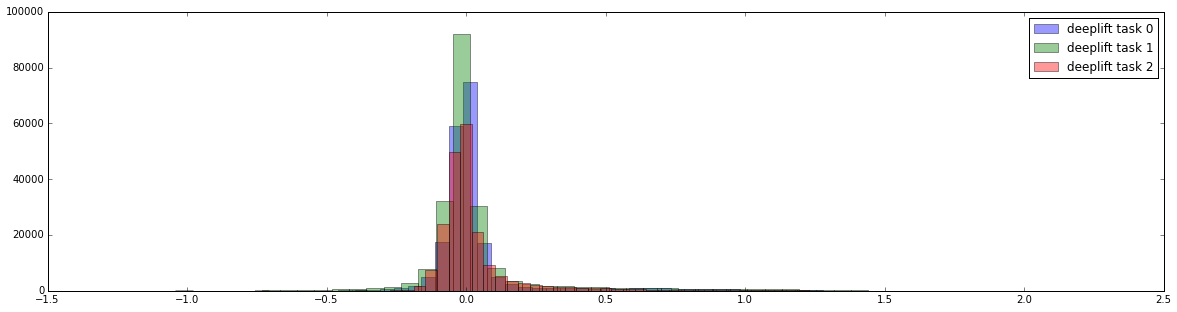

grad_times_inp


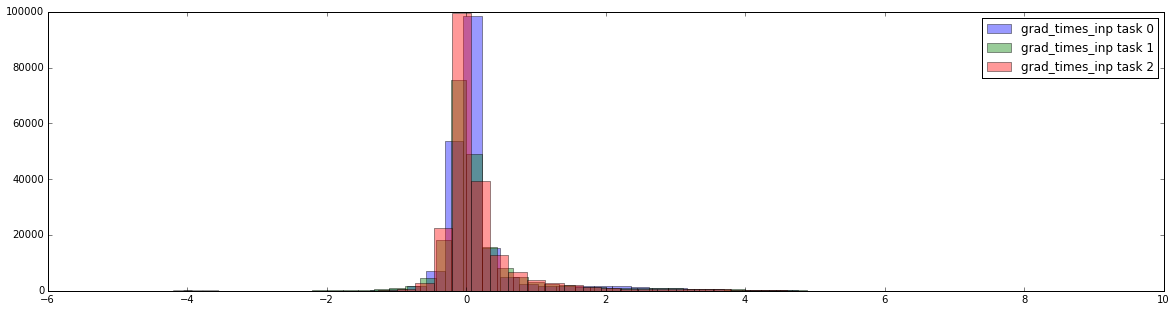

guided_backprop_times_inp


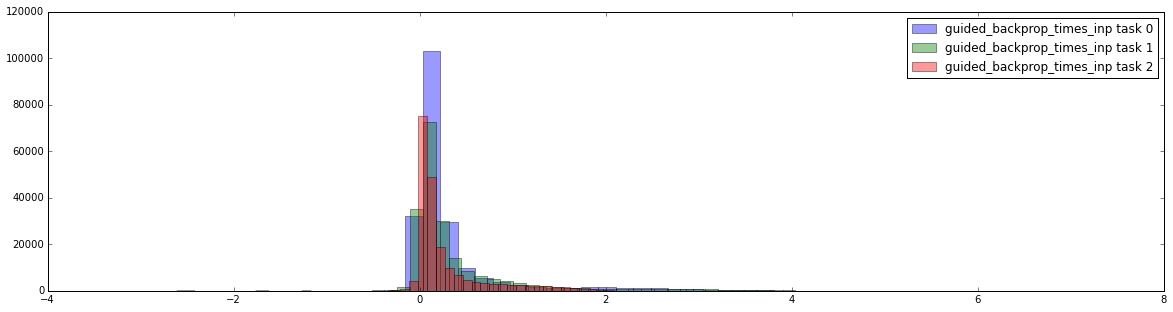

guided_backprop_deeplift_times_inp


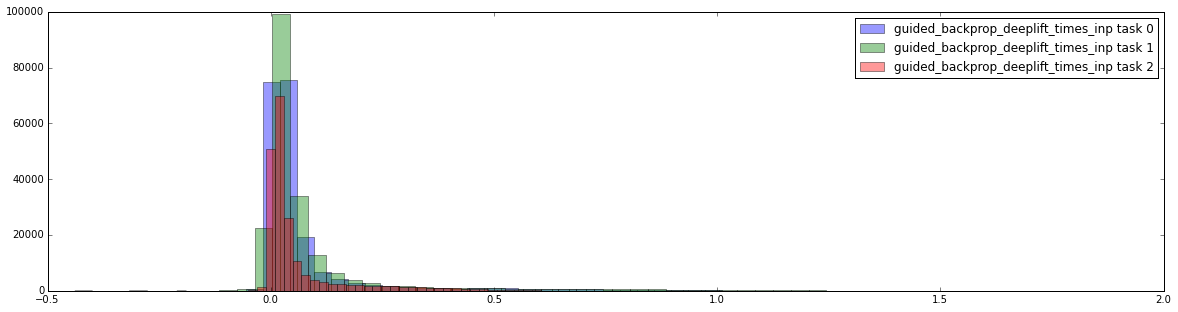

deeplift_pos_through_dense


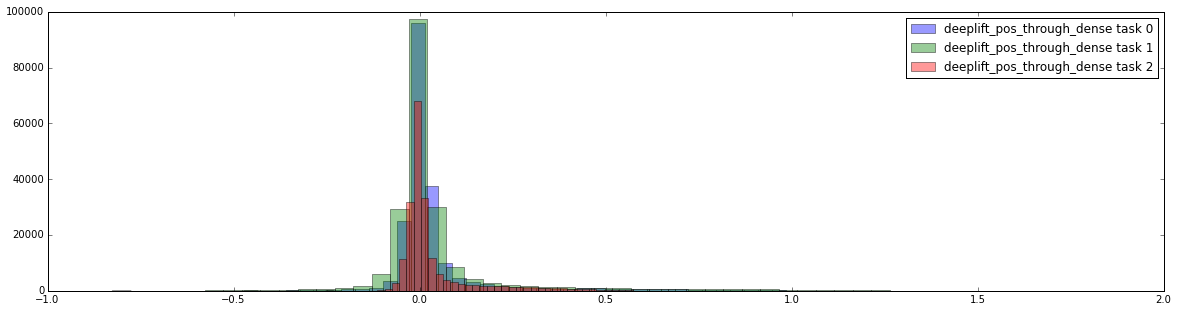

In [13]:
import matplotlib.pyplot as plt
for method in method_to_task_to_scores:
    print(method)
    plt.figure(figsize=(20,5))
    for task_idx in [0,1,2]:
       plt.hist(np.concatenate(method_to_task_to_scores[method][task_idx],axis=0).ravel(),
                                label=method+" task "+str(task_idx), bins=50,alpha=0.4)
    plt.legend()
    plt.show()
    

Task 0
deeplift mean: 0.764419498975
grad_times_inp mean: 0.723880565342
guided_backprop_times_inp mean: 0.661220100887
guided_backprop_deeplift_times_inp mean: 0.699882552268
deeplift_pos_through_dense mean: 0.700456898753


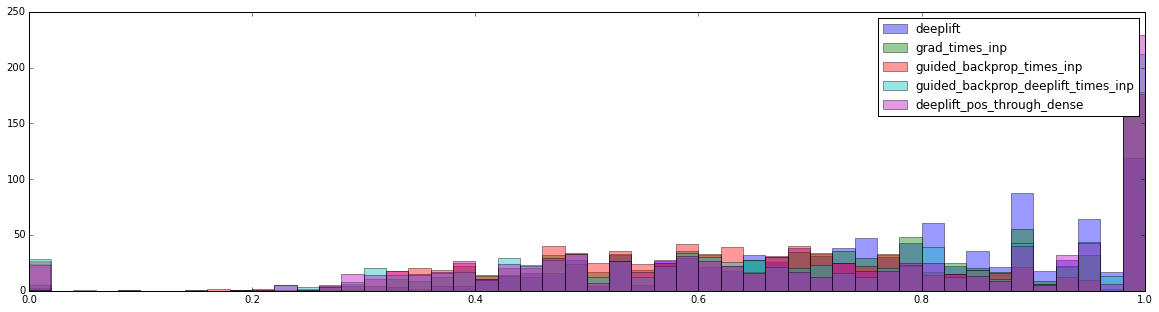

Task 1
deeplift mean: 0.837712366932
grad_times_inp mean: 0.73571361075
guided_backprop_times_inp mean: 0.693140906359
guided_backprop_deeplift_times_inp mean: 0.808474438398
deeplift_pos_through_dense mean: 0.814214566387


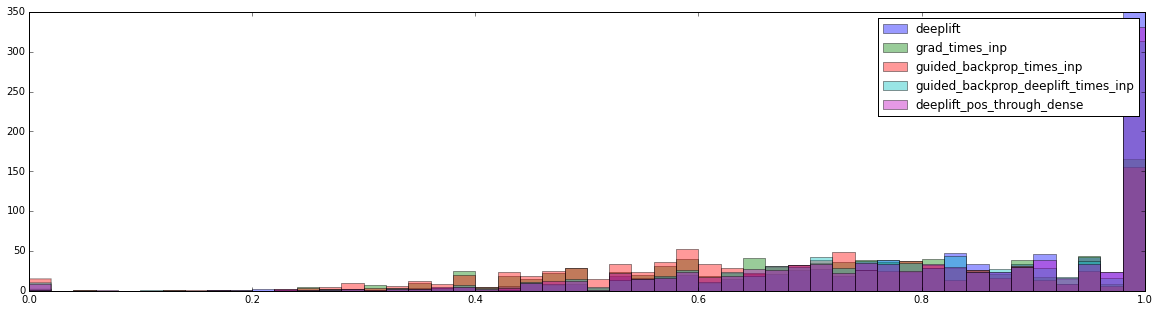

Task 2
deeplift mean: 0.885331170033
grad_times_inp mean: 0.765956010842
guided_backprop_times_inp mean: 0.899246561642
guided_backprop_deeplift_times_inp mean: 0.961065926011
deeplift_pos_through_dense mean: 0.965086915864


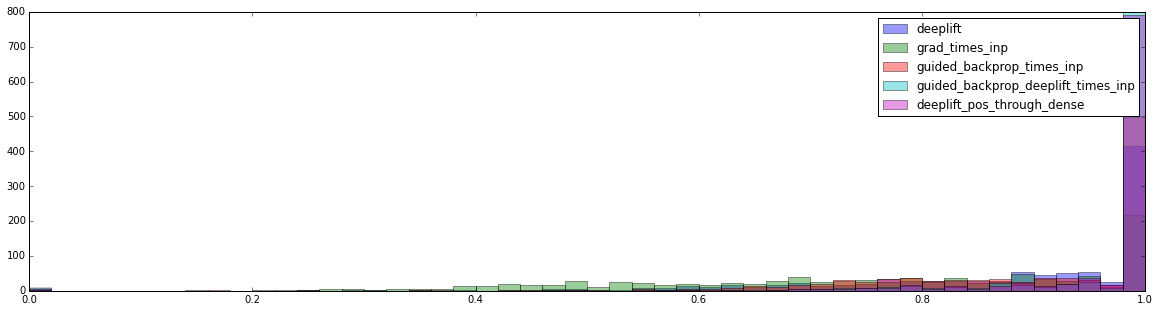

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from deeplift.visualization import matplotlib_helpers as mplh
reload(mplh)

for task_idx, motif_locs in [(0, motif_locations['GATA_disc1']),
                                  (1, motif_locations['TAL1_known1']),
                                  (2, [x+y for x,y in zip(motif_locations['GATA_disc1'],
                                                          motif_locations['TAL1_known1'])])]:
    print("Task "+str(task_idx))
    method_to_proportion = {}
    plt.figure(figsize=(20,5))
    for method in method_to_task_to_scores:
        proportion_on_valid_locations = compute_proportion_of_scores_on_valid_locations(
            method_to_task_to_scores[method][task_idx], motif_locs)
        print(method+" mean: "+str(np.mean(proportion_on_valid_locations)))
        plt.hist(proportion_on_valid_locations, label=method, bins=50, alpha=0.4)
    plt.legend()
    plt.show()

Visualize the scores at the sequence predicted most confidently. Cyan boxes indicate the ground-truth locations of the inserted TAL1_known1 motifs, red boxes indicate the ground-truth locations of the inserted GATA_disc1 motifs

deeplift


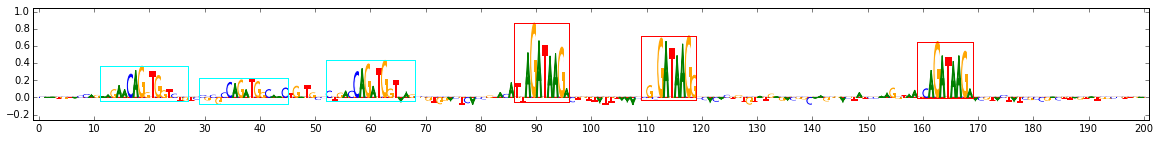

grad_times_inp


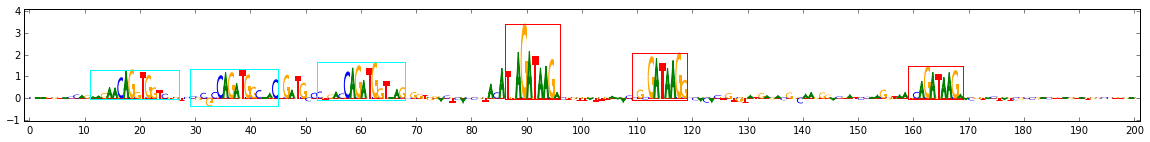

guided_backprop_times_inp


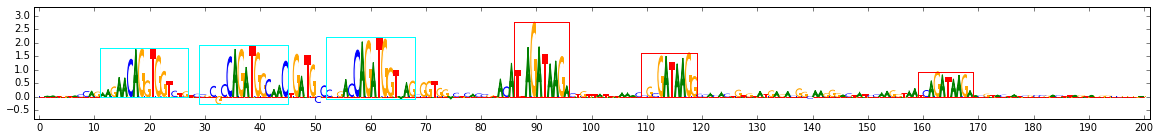

guided_backprop_deeplift_times_inp


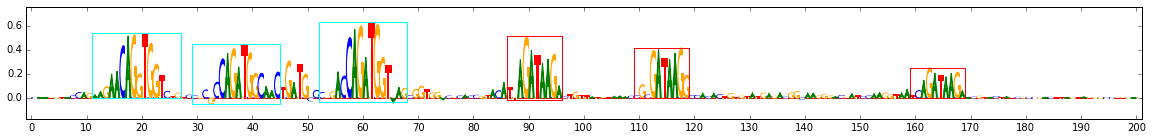

deeplift_pos_through_dense


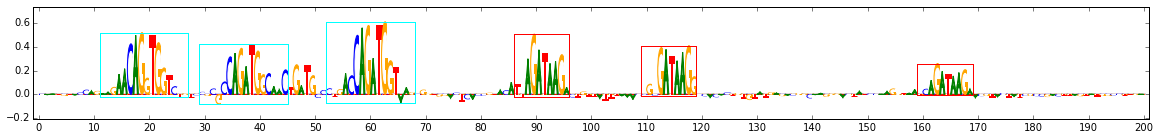

In [15]:
#visualize scores + ground-truth locations of motifs
%matplotlib inline
from deeplift.visualization import viz_sequence
reload(viz_sequence)

sorted_idx = 0
idx = tal_gata_predictions_sorted[sorted_idx][0]

for method_name in method_to_task_to_scores:
    scores = method_to_task_to_scores[method_name][2]
    scores_for_idx = scores[idx]
    original_onehot = tal_gata_onehot[idx]
    scores_for_idx = original_onehot*scores_for_idx[None,None,:]
    print(method_name)
    highlight = {'red':motif_locations['GATA_disc1'][idx],
                 'cyan':motif_locations['TAL1_known1'][idx]}
    viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight=highlight)